##### Project 2 - Big-Scale Analytics 
##### Team ROLEX - Samuel Lew, Alexandre Lang, Samy Bouzerda, Alix Muller
-------
# Kaggle: Real or Not? NLP with Disaster Tweets
-------

# 0. Dataset
This competition's Dataset shows a set of tweets divided into a training and a test set. The training set has a column named 'target' that permits to identify if the tweet contains an infomation about a disaster or not.

For example, here are one tweet about a disaster and another not:

In [15]:
# A disaster tweet
disaster_tweet = train[train['target'] == 1]['text']
disaster_tweet.values[1]

'A subcontractor working for French seismic survey group CGG has been kidnapped in Cairo and is held by Islamic State the company said on W\x89Û_'

In [16]:
# A tweet not concerning a disaster
non_disaster_tweet = train[train['target'] == 0]['text']
non_disaster_tweet.values[1]

'Kids are inundated with images and information online and in media and have no way to deconstruct. - Kerri Sackville #TMS7'

In this competition, people have to create a machine learning model to predict whether the tweets test set mention a disaster or not. This challenge is a binary classification problem.

# I. Importing libraries and dataset

In [30]:
import pandas as pd

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# libraries for textprocessing
import string

!pip install spacy
!python -m spacy download en
import spacy

import re
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from nltk.corpus import stopwords
import nltk

parser = English()
nlp = spacy.load('en')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
punctuations = string.punctuation

  Using cached https://files.pythonhosted.org/packages/39/c9/6c6bbb563588cd9b5d155ebda200796911588fb46a85e5f4d21b7b2ab759/spacy-2.2.4-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/84/d1/35eab0c8cc9fd9432becaf3e90144762b3201a45079e62c47a8ae8739763/cymem-2.0.3-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/6c/f9/9a5658e2f56932e41eb264941f9a2cb7f3ce41a80cb36b2af6ab78e2f8af/catalogue-1.0.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/c9/40/058b12e8ba10e35f89c9b1fdfc2d4c7f8c05947df2d5eb3c7b258019fda0/tqdm-4.46.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/86/85/40b8f66c2dd8f4fd9f09d59b22720cffecf1331e788b8a0cab5bafb353d1/plac-1.1.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/5e/d7e297587f75f4932b57b47163fb92f7b479939327ca83badc0938194415/thinc-7.4.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] Access is denied: 'c:\\programdata\\anaconda3\\lib\\site-packages\\importlib_metadata-0.17.dist-info\\INSTALLER'
Consider using the `--user` option or check the permissions.

C:\ProgramData\Anaconda3\python.exe: No module named spacy


ModuleNotFoundError: No module named 'spacy'

In [ ]:
train = pd.read_csv('../data/train.csv')
train = train.sample(frac=1, replace=False)
train = train[['id', 'keyword', 'location', 'text', 'target']]
train.shape

test = pd.read_csv ('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'text']]


train.head(10)

# II. EDA

## 1. Training set

### Distribution of the target column

In [23]:
total_count = 0
for row in train.iterrows():
  total_count += 1
print(f'There are {total_count} tweets in the dataset')

train_yes = train.query('target == 1')
yes_count = 0
for row in train_yes.iterrows():
    yes_count += 1
print(f'There are {yes_count} tweets about disasters')

train_no = train.query('target == 0')
no_count = 0
for row in train_no.iterrows():
    no_count += 1
print(f'There are {no_count} tweets that are not about disasters')

print('The classification base rate is ' + str(yes_count/(yes_count+no_count)*100)[:5] + '%')

There are 7613 tweets in the dataset
There are 3271 tweets about disasters
There are 4342 tweets that are not about disasters
The classification base rate is 42.96%


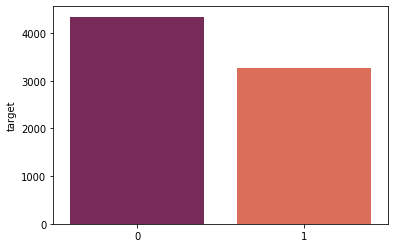

In [26]:
sns.barplot(train['target'].value_counts().index, train['target'].value_counts(), palette = 'rocket')

### Distribution of the Keyword column

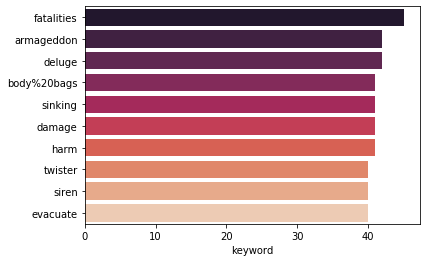

In [27]:
sns.barplot(y = train['keyword'].value_counts()[:10].index, x = train['keyword'].value_counts()[:10], orient='h', palette = 'rocket')

In [28]:
train.loc[train['Tweet text'].str.contains('disaster', na=False, case=False)].Target.value_counts()

KeyError: 'Tweet text'

## 2. Test set

### Data loading

In [ ]:
test = pd.read_csv('../data/test.csv')
test = test.sample(frac=1, replace=False)
test = test[['id', 'keyword', 'location', 'text']]
test.shape

In [ ]:
test.columns = ['ID', 'Keyword', 'Location', 'Tweet text']
test.head()

### Distribution of the Keyword column

In [ ]:
sns.barplot(y = test['Keyword'].value_counts()[:10].index, x = test['Keyword'].value_counts()[:10], orient='h', palette = 'rocket')

# III. Data preprocessing and tokenisation

In [ ]:
# Applying a first round of text cleaning techniques
#Make text lowercase and remove text in square brackets, links, punctuation, words containing numbers.

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

# Applying the cleaning function to the dataset
train['Tweet text'] = train['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
train['Tweet text'].head()

In [ ]:
# Applying the cleaning function to the dataset
test['Tweet text'] = test['Tweet text'].apply(lambda x: clean_text(x))

# Updated text
test['Tweet text'].head()

In [ ]:
# Tokenising the training and test set
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

train['Tweet text'] = train['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
train['Tweet text'].head()

In [ ]:
test['Tweet text'] = test['Tweet text'].apply(lambda x: tokenizer.tokenize(x))
test['Tweet text'].head()

In [ ]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['Tweet text'] = train['Tweet text'].apply(lambda x : remove_stopwords(x))
train['Tweet text'].head()

In [ ]:
test['Tweet text'] = test['Tweet text'].apply(lambda x : remove_stopwords(x))
test['Tweet text'].head()

# IV. Classification models


## 1. KNN classifier
The k-nearest neighbors algorithm (k-NN) is a non-parametric method used for classification (and also regression). In k-NN classification, The input consists of the k closest training examples in the feature space. The output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors.

In [ ]:
from sklearn.model_selection import train_test_split

X = train['Tweet text']
ylabels = train['Target']


print('X shape: ', X.shape)
print('y shape: ', ylabels.shape)

X.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the training set
word_vectorizer = CountVectorizer()
X_train = word_vectorizer.fit_transform(train['Tweet text'].map(lambda words: ', '.join(words)))

# Vectorize the testing test
X_test = word_vectorizer.transform(test['Tweet text'].map(lambda words: ', '.join(words)))

# Our output variable "target" which indicates whether a tweet is diaster tweet
y_train = train['Target']

X_train.shape

In [ ]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train)
print(scores.mean())

In [ ]:
BNB = BernoulliNB()
scores = cross_val_score(BNB, X_train, y_train)
print(scores.mean())

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3, weights = 'uniform')
scores = cross_val_score(knn, X_train, y_train)
print(scores.mean())

In [ ]:
y_test = train['Tweet text']
preds = clf.predict(y_test)

sub_train['Target'] = preds
sub_df.to_csv("submission.csv",index=False)